In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd/content/gdrive/My Drive/Recommed System

/content/gdrive/My Drive/Recommed System


In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

In [4]:
columns_name=['user_id','item_id','rating']
req_cols = ['user_id', 'book_id', 'rating']
df = pd.read_csv('goodreads_interactions.csv', nrows=100000, usecols=req_cols) 
print(len(df))
display(df.head(5))


100000


,user_id,book_id,rating
0,0,948,5
1,0,947,5
2,0,946,5
3,0,945,5
4,0,944,5


In [5]:
df = df[df['rating']>=3]  #별점 5점만점이면 3점이상부터 연결되어있다고 봐야하는건가?
print(len(df))

40703


In [6]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    10444
4    16191
5    14068
Name: rating, dtype: int64

In [7]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)

In [8]:
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  32562
Test Size :  8141


In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values) #values로 list만들어 놓고 인코더(인덱스를 붙여주는일)
train['item_id_idx'] = le_item.fit_transform(train['book_id'].values)
train

,user_id,book_id,rating,user_id_idx,item_id_idx
0,138,13227,4,137,4737
1,91,26007,4,91,10862
2,73,22841,3,73,9521
3,161,43470,4,160,16431
4,2,1146,3,2,697
...,...,...,...,...,...
32557,214,48688,5,213,18754
32558,182,6866,4,181,2288
32559,182,6868,5,181,2290
32560,13,8402,4,13,3179


In [10]:
#userid,itemid의 유니크값을 따로 추출해서(리스트로 반환됨)
train_user_ids = train['user_id'].unique()
train_item_ids = train['book_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['user_id'].isin(train_user_ids)) & (test['book_id'].isin(train_item_ids))] #train에서 있었던 유저와 아이템만을 test로만들음(나중에 topk 할때 좀더 이해 됨)
print(len(test))

227 21075
3809


In [11]:
test['user_id_idx'] = le_user.transform(test['user_id'].values) #인코딩 되었던 유저,아이템 인덱스를 테스트에도 똑같이 적용
test['item_id_idx'] = le_item.transform(test['book_id'].values)

In [12]:
test

,user_id,book_id,rating,user_id_idx,item_id_idx
0,166,7351,5,165,2625
1,167,128,4,166,45
3,109,29277,5,109,12185
4,130,22415,5,129,9284
9,210,5803,5,209,1899
...,...,...,...,...,...
8131,132,7176,5,131,2492
8133,189,6856,4,188,2283
8136,172,16217,4,171,6364
8138,165,4512,5,164,1567


In [13]:
 test_interacted_items = test.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
 test_interacted_items

,user_id_idx,item_id_idx
0,0,"[132, 111, 197, 146, 496, 236, 148, 85, 413, 190, 252, 284, 466, 73, 507, 534, 185, 393, 539, 91, 462, 543, 395, 102, 210, 169, 108, 315, 222, 431, 201, 299]"
1,1,"[593, 624, 619, 582, 542, 552, 574, 117, 600, 580, 543, 609, 606]"
2,2,"[540, 686, 714, 670, 456, 648, 678, 741, 579, 470, 668, 207, 715, 259, 17, 14, 771, 660, 677, 758, 766, 755, 570, 525, 687, 709, 736]"
3,3,"[864, 870, 838]"
4,4,"[1006, 924, 194, 979, 832, 933, 906, 992, 1003, 1011, 839, 780, 914, 982, 929, 993, 102, 84, 850, 946, 1001, 959, 847, 930, 935]"
...,...,...
215,222,"[2059, 579, 270, 1777, 18038, 1000, 6043, 13704, 575, 249, 569, 1014, 283, 5604, 257, 1542, 537, 10121, 6022]"
216,223,"[3170, 592, 2638, 456, 6850, 8110, 6904, 488, 3219, 2653, 145, 252, 4561, 4730, 4606, 2642, 315, 569, 2060, 4711, 8676, 44, 885, 14857, 310, 192, 259, 6697, 474]"
217,224,"[14392, 554, 2509, 749, 7542, 2858, 1317, 3223, 3349, 932, 4899, 8474, 19302, 2376, 1624, 840, 6452, 3187, 116, 15187, 17956, 15486, 950, 4565, 2620, 4902, 757, 398, 798, 10910, 7934, 4882, 16798, 13751]"
218,225,"[11755, 8438, 9494, 2014, 538, 1566, 20299, 9825, 5135, 7842, 12370, 8437, 20510, 1563, 2525, 7903, 9371, 4779, 14702, 1400, 2012, 7888, 5012, 295, 7858, 5698, 6408, 7989, 1814, 2299, 4989, 14715, 2467, 5680, 1606, 252, 19234, 9081, 15, 11520, 1558, 1480, 1609, 7854, 5017, 20298, 1568, 847, 18084, 15272, 537, 1608, 17875, 1272, 10801, 17873, 8957, 543, 6081, 3482, 4591, 20297, 5795, 4773, 9363, 331, 1276, 9492, 6086]"


In [14]:
n_users = train['user_id_idx'].nunique() #유저 수
n_items = train['item_id_idx'].nunique() #책 수
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  227
Number of unique Items :  21075


In [15]:
latent_dim = 64 #임베딩 시킬 차원
n_layers = 3  #레이어 층 수

In [16]:
def convert_to_sparse_tensor(dok_mtrx): #dok matrix를 받아서 coo matrix로 돌려서 값과 인덱스를 뽑아내고 
# 값들을 텐서로 바꾼 다음 torch sparse텐서로 값들을 넣어서 만들어준다. 
# 이렇게하면 to_indense함수를 쓸수 있다.
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [17]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)  #엠베딩 유저개수 by 임베딩 차원 엠베딩 형식으로 만든다 (원래는 weight?)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts) 

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique()) #테스트 데이터 안에서 유니크안 유저의 id를 텐서로 만듬

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1)) #score 측정 train데이타에 있는 각각의쌍들의 점수가 나옴

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32) #https://radish-greens.tistory.com/1
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0 #train data에있는 유저 아이템 상호작용 정보를 matrix로

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense() #https://pytorch.org/docs/stable/generated/torch.Tensor.to_dense.html

    R_tensor_dense = R_tensor_dense*(-np.inf) #1로 이미 상호작용하였던 정보는 -무한대로 만들어줌(쓰지 않을 정보)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0) #https://pytorch.org/docs/stable/generated/torch.nan_to_num.html#torch.nan_to_num

    relevance_score = relevance_score+R_tensor_dense #-무한대를 제외한 모든 유저아이템 정보의 내적값으로 채워들어감(이부분에서 test를 예측할수있는 느낌이 나옴! test정보는 여기 없으니 -무한대로 걸러지지 않음)

    topk_relevance_score = torch.topk(relevance_score, K).values #https://pytorch.org/docs/stable/generated/torch.topk.html (행이 여러개면 행마다 나옴)
    topk_relevance_indices = torch.topk(relevance_score, K).indices 

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
 
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']] #https://numpy.org/doc/stable/reference/generated/numpy.vstack.html 각 유저의 내적이 높은 k개의 인덱스의 정보

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index() #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID']) #https://antilibrary.org/2483
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)] #https://www.daleseo.com/python-zip/
  #test데이터에있는 item인덱스와 내가만든 k개정보를 조인해서 겹치는 부분의 인덱스를 가지고 있는 프레임을 만듬

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)  #https://wikidocs.net/46758 # recallk의 metric
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean(),metrics_df #epoch당 평균 recallk값을 반환

In [18]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data #train
        self.n_users = n_users #train 유저 
        self.n_items = n_items #train 아이템
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self): #유저와 아이템의 수만큼 임베딩을 만들어주고 그 차원은 latent_dim
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight) #자비에 정규화(인공지능)
        self.E0.weight = nn.Parameter(self.E0.weight) #임베딩 공간의 파라미터만 가지고있는 변수

    def get_A_tilda(self): #diffusion matrix 만드는 코드
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32) #유저와 아이템의 개수만큼 dok matrix size 설정
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0 #실제로 유저와 아이템 상호작용한 인덱스의 1 추가 (여기서는 rating 3이상이 상호작용 기준이였음)

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            ) #유저수+책 by 유저수+아이템 사이즈로 인접행렬을 만들기위해 생성
        adj_mat = adj_mat.tolil() # 리스트로 만들어줌 인덱싱하기 위함
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T #채워넣음
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1)) #행 마다 합계 -> 연결된 부분을 1씩 더하는거니까 한 유저가 본 아이템개수가 각각 나옴
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten() # 각 원소들을 루트 적용후 분수만들음
        d_inv[np.isinf(d_inv)] = 0.0 #유저가 한개도 안본 경우? 
        d_mat_inv = sp.diags(d_inv) #degree matrix로 변환
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        
        
        
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col)) #https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
        #indice는 현재 pyg에 edge_index처럼 있음
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor
    
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding) #https://sanghyu.tistory.com/85
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0) #https://pytorch.org/docs/stable/generated/torch.mean.html#torch.mean

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed # E(k)를 가지고 유저랑 아이템 임베딩 나눠서 리턴

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items] #샘플링된 유저와 그에 각각 대응하는 하나의 pos,neg 임베딩을 가져옴
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [19]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

In [20]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([21302, 64])


In [21]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    #----------------------------------------------------------------------#
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores)) #softplus라는 relu의 근사화된 활성화 함수를 사용 / 마이너스위치 바꿔주면서 -가 빠짐 https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html
        
    return loss, reg_loss

In [22]:
def data_loader(data, batch_size, n_usr, n_itm):
  
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index() 
    #https://colab.research.google.com/drive/1GdToVW9iBMyz6lZpN3zELK1G_S9kYLIg#scrollTo=1pbMS22wusZ3&line=2&uniqifier=1 이런 형식으로 됨
  
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1) #아이템 id하나 고르셈
            if neg_id not in x: #apply에서 넘어온 한 유저의 item_idx에서 없으면 그거 return 그걸 각각 유저마다 다해서 리스트를 만듬
                return neg_id
  
    indices = [x for x in range(n_usr)] #유저 수 만큼 인덱스를 만들음 
    
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else: #유저가 배치사이즈보다 크면 배치사이즈만큼 유저를 샘플링해서 유저의 인덱스 몇개만 사용
        users = random.sample(indices, batch_size) 

    users.sort() #인덱스 정렬
  
    users_df = pd.DataFrame(users,columns = ['users']) #샘플링된 유저의 인덱스를 프레임으로 만들음

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users') #샘플링된 유저가 읽은 책정보를 가져온다.
  
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values #샘플링된 유저 각각이 읽은 책정보중에서 하나 씩 랜덤으로 뽑아 리스트 만들음 즉 리스트사이즈는 1024
                                                                                              #https://wikidocs.net/79
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values # 의문점: 네거티브 에지도 하나만뽐아서 목적함수에 넣어서 학습시킴 (개선점?)

    return list(users), list(pos_items), list(neg_items)

In [23]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [24]:
EPOCHS = 30
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 50

In [25]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = [] 

for epoch in (range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    best_ndcg = -1
  
    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
    
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map ,seokjin = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg
      
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')
     

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)  

In [26]:
epoch_list = [(i+1) for i in range(EPOCHS)]

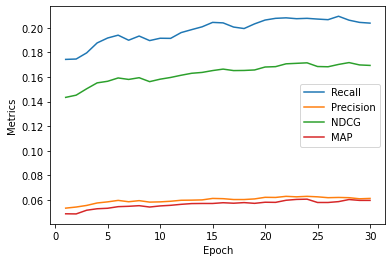

In [31]:

plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

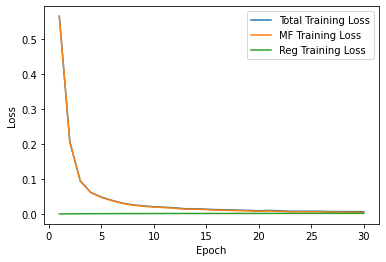

In [28]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [29]:
seokjin

,user_id_idx,item_id_idx,user_ID,top_rlvnt_itm,intrsctn_itm,recall,precision,hit_list,ndcg,hit_list_cumsum,map
0,0,"[132, 111, 197, 146, 496, 236, 148, 85, 413, 190, 252, 284, 466, 73, 507, 534, 185, 393, 539, 91, 462, 543, 395, 102, 210, 169, 108, 315, 222, 431, 201, 299]",0,"[4738, 676, 585, 2625, 747, 734, 2717, 2532, 413, 197, 263, 995, 3200, 3204, 1423, 222, 637, 395, 7080, 567, 4835, 9359, 743, 4581, 584, 8680, 2677, 9358, 683, 4457, 252, 7796, 8693, 2466, 7568, 58, 2623, 4639, 16188, 7075, 16186, 310, 294, 4598, 16187, 543, 6978, 3222, 845, 16189]","[197, 395, 252, 413, 222, 543]",0.187500,0.12,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0.151696,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6]",0.031642
1,1,"[593, 624, 619, 582, 542, 552, 574, 117, 600, 580, 543, 609, 606]",1,"[252, 574, 542, 474, 413, 224, 840, 283, 839, 394, 440, 674, 676, 379, 847, 249, 2625, 456, 58, 757, 3222, 543, 212, 747, 197, 746, 525, 395, 3231, 2534, 2486, 259, 223, 774, 886, 4651, 2516, 499, 885, 5999, 758, 3207, 832, 380, 764, 2692, 2489, 873, 2666, 9120]","[543, 574, 542]",0.230769,0.06,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.252455,"[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",0.100233
2,2,"[540, 686, 714, 670, 456, 648, 678, 741, 579, 470, 668, 207, 715, 259, 17, 14, 771, 660, 677, 758, 766, 755, 570, 525, 687, 709, 736]",2,"[252, 885, 525, 470, 379, 574, 249, 579, 3222, 627, 6042, 840, 2625, 758, 540, 4906, 618, 1419, 4651, 543, 294, 471, 382, 456, 1418, 850, 9120, 773, 616, 839, 2821, 847, 135, 832, 886, 2667, 4738, 576, 581, 2666, 3207, 4599, 4547, 2453, 463, 145, 6728, 197, 84, 2622]","[579, 456, 525, 470, 758, 540]",0.222222,0.12,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.230107,"[0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",0.076940
3,3,"[864, 870, 838]",3,"[986, 84, 656, 4809, 379, 850, 4897, 580, 8396, 4574, 10107, 907, 627, 4894, 4910, 249, 1419, 577, 194, 2782, 5530, 2499, 4811, 2776, 4595, 4868, 804, 915, 4819, 4792, 4873, 251, 954, 542, 4806, 572, 4887, 2516, 585, 757, 4886, 4804, 583, 4856, 857, 20, 997, 4855, 4907, 4568]",[],0.000000,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000
4,4,"[1006, 924, 194, 979, 832, 933, 906, 992, 1003, 1011, 839, 780, 914, 982, 929, 993, 102, 84, 850, 946, 1001, 959, 847, 930, 935]",4,"[252, 542, 839, 574, 573, 847, 757, 538, 583, 295, 84, 585, 249, 474, 2625, 540, 993, 627, 2516, 379, 554, 543, 584, 832, 380, 537, 850, 676, 2486, 2889, 456, 283, 58, 674, 756, 2534, 579, 382, 3222, 746, 2517, 197, 4574, 747, 2945, 4621, 656, 2343, 2376, 2611]","[832, 993, 839, 847, 850, 84]",0.240000,0.12,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.221147,"[0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",0.064210
...,...,...,...,...,...,...,...,...,...,...,...
215,222,"[2059, 579, 270, 1777, 18038, 1000, 6043, 13704, 575, 249, 569, 1014, 283, 5604, 257, 1542, 537, 10121, 6022]",222,"[

In [30]:
from scipy.sparse import dok_matrix
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

m = dok_matrix((3, 4)) # 값이 0으로 채워진 (3, 4) 크기의 행렬을 만듭니다.
m[0, 1] = 4
m[2, 3] = 9
print(m)


  (0, 1)	4.0
  (2, 3)	9.0
